In [1]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
import pandas as pd
import torch
import numpy as np

df = pd.read_csv("/content/filter_dataset.csv")
df = df[['Essay', 'Overall']].dropna()

# For Classification
def map_score_to_band(score):
    if score < 5.0:
        return 0
    elif score < 6.0:
        return 1
    elif score < 7.0:
        return 2
    elif score < 8.0:
        return 3
    else:
        return 4

df['Band'] = df['Overall'].apply(map_score_to_band)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Essay'].tolist(), df['Band'].tolist(), test_size=0.2, random_state=42
)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
class EssayDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EssayDataset(train_texts, train_labels, tokenizer)
test_dataset = EssayDataset(test_texts, test_labels, tokenizer)

# BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5) # Classification

# TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_steps=10,
)


def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shethprachi1111 (shethprachi1111-hochschule-bonn-rhein-sieg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,1.523300
20,1.360100
30,1.343600
40,1.401200
50,1.253400
60,1.234800
70,1.143900
80,1.180100
90,0.994600
100,1.080500


TrainOutput(global_step=240, training_loss=1.0225014766057332, metrics={'train_runtime': 12582.9119, 'train_samples_per_second': 0.151, 'train_steps_per_second': 0.019, 'total_flos': 500450706966528.0, 'train_loss': 1.0225014766057332, 'epoch': 3.0})

In [2]:
model.save_pretrained("./bert-band-model")
tokenizer.save_pretrained("./bert-band-model")


('./bert-band-model/tokenizer_config.json',
 './bert-band-model/special_tokens_map.json',
 './bert-band-model/vocab.txt',
 './bert-band-model/added_tokens.json')

In [3]:
from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained("./bert-band-model")
tokenizer = BertTokenizer.from_pretrained("./bert-band-model")


In [10]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

preds = trainer.predict(test_dataset)
predictions = np.argmax(preds.predictions, axis=1)
true = preds.label_ids

band_names = ["<5", "5", "6", "7", "8+"]

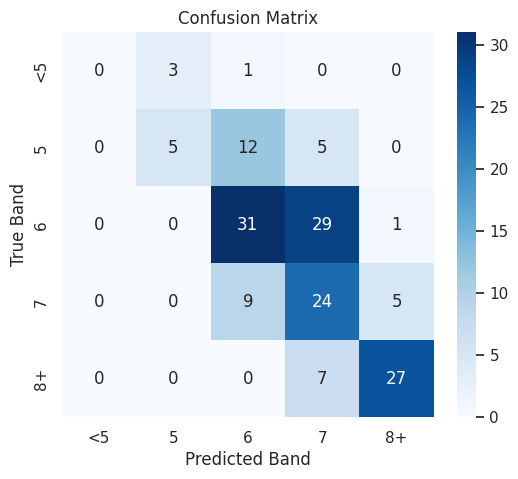

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(true, predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=band_names, yticklabels=band_names)
plt.xlabel('Predicted Band')
plt.ylabel('True Band')
plt.title('Confusion Matrix')
plt.show()


In [6]:
# Feedback
import spacy
nlp = spacy.load("en_core_web_sm")

def generate_feedback(essay):
    feedback = []
    doc = nlp(essay)

    # Sentence length
    sentences = list(doc.sents)
    avg_len = sum(len(sent) for sent in sentences) / len(sentences)
    if avg_len < 12:
        feedback.append("• Try to write longer and more detailed sentences.")

    # Lexical diversity
    words = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    unique_words = set(words)
    diversity = len(unique_words) / (len(words) + 1e-5)
    if diversity < 0.4:
        feedback.append("• Improve vocabulary by avoiding repetition.")

    # Linking words
    transitions = ["however", "therefore", "moreover", "for example"]
    if not any(t in essay.lower() for t in transitions):
        feedback.append("• Add transition words (e.g., 'however', 'moreover') to improve coherence.")

    return feedback or ["✓ Well-structured essay with good coherence and vocabulary."]


In [7]:
def predict_band_and_feedback(essay, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(essay, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    outputs = model(**inputs)
    predicted_band = torch.argmax(outputs.logits, dim=1).item()

    band_map = {0: "<5", 1: "5", 2: "6", 3: "7", 4: "8+"}
    band = band_map[predicted_band]
    feedback = generate_feedback(essay)

    return band, feedback


In [16]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

example_essay = df['Essay'].iloc[0]
band, feedback = predict_band_and_feedback(example_essay, model, tokenizer, device)

print(f"Predicted Band: {band}")
print("Feedback:")
for f in feedback:
    print(f)


Predicted Band: 6
Feedback:
✓ Well-structured essay with good coherence and vocabulary.
